# Chronos
- There are several Transformer-Based approaches for Time-Series Forecasting
- We present here Chronos because:
    - It is young --> large potential for improvement
    - It is relatively simple, yet highly accurate
        - It can use standard Large Language Models (LLMs) like  GPT, T5, LLama, BERT, etc.
        - The only thing it adjusts is its Tokenizer, meaning:
            - LLMs represent text as such called Tokens - Word Parts like "Hel", and "-lo"
            - Those get mapped to Vectors, because LLMs can't work with words nor such tokens directly (they aren't numbers)
                - "Hel" --> [0.1, 0.4, 0.2, 0.1]
                - "-lo"  --> [0.3, 0.2, 0.5, 0.6]
                - Tokenization is still important as it allows representing all words in a language much more efficiently than mapping each word (like "dog", "dogs", "dog-lover") directly to a vector 
                    - Similar to how 26 letters suffice to write any english word
                    - Side-Note: 26 Letters (+ some special characters e.g. "." and " ") would hence suffice as tokens to encode text but longer tokens allow:
                        - representing the same amount of text in fewer tokens (i.e. vectors) which is computational less demanding 
                        - encode more meaning in those vectors to represent more intricate patterns, e.g.      
                            - The token "dog" likely means something related to the animal hence its vector could be used to represent such a meaning  
                            - The token "d" on the other hand could stand in any context from "d"eath, and "d"og, to "d"ora and "d"iggah hence its vector representation would need to be much more generic    
                        - For Further Information we recommend 3Blue1Brown's Videos on Transformers, like [Intro to Transformers](https://www.youtube.com/watch?v=wjZofJX0v4M) and [Explanation of Attention Function](https://www.youtube.com/watch?v=eMlx5fFNoYc) or the [Original Transformer Paper](https://user.phil.hhu.de/~cwurm/wp-content/uploads/2020/01/7181-attention-is-all-you-need.pdf)
            - The Tokenizer it uses is relatively simple:
                - First it Scales the Time-Series so that all are on a somewhat similar scale e.g. between -1 and +1 (Note: It uses an approach such that values outside a certain range are still possible but should be rare --> Very extreme Values can't be represented and forecast by it) 
                - Then it discretizes them by placing them in buckets e.g. 0.120147289 becomes 0.1 and 0.18252720 becomes 0.2
                - Those buckets are then treated like text tokens meaning "0.2" ≱ "0.1" as "Hel" ≱ "-lo", In other words they aren't comparable yet 
                - The Model then needs to learn the Vector Representations of those token, e.g. "0.1" --> [0.1, 0.5, 0.2, 0.3]
    - Other LLM (i.e. Transformer)-based approaches make strong adjustments to the underlying architecture and are hence fairly complex, but are not necessarily better, and new breakthroughs from LLMs are harder to apply to them than to Chronos

In [4]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git
!pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu121

  Cloning https://github.com/amazon-science/chronos-forecasting.git to c:\users\poehlmann\appdata\local\temp\pip-req-build-qmp3cqty
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit eb7bdfc047de3e7af972b4ee7cf23a7968b7daa3
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git 'C:\Users\poehlmann\AppData\Local\Temp\pip-req-build-qmp3cqty'

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu121

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\poehlmann\\PycharmProjects\\BTW25\\.venv\\Lib\\site-packages\\~orch\\lib\\asmjit.dll'
Check the permissions.


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 0.0/4.1 MB ? eta -:--:--
     ------- -------------------------------- 0.8/4.1 MB 23.7 MB/s eta 0:00:01
     --------------------- ------------------ 2.1/4.1 MB 27.3 MB/s eta 0:00:01
     ------------------------- -------------- 2.6/4.1 MB 27.2 MB/s eta 0:00:01
     ---------------------------------------  4.1/4.1 MB 23.5 MB/s eta 0:00:01
     ---------------------------------------- 4.1/4.1 MB 21.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/2.4 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 GB 33.1 MB/s eta 0:01:14
     ---------------------------------------- 0.0/2.4 GB 32.7 MB/s eta 0:01:15
     ---------------------------------------- 0.0/2.4 GB 30.6 MB/s eta 0:01:20
     ---------------------------------------- 0.0/2.4 GB 27.8 MB/s eta 0:01:27
     ---------------------------------------- 0.0/2.4 GB 31.4 MB/s eta 0:01:17
     ---------------------------------------- 0.0/2.4 GB 30.8 MB/s 

In [ ]:
# Download the Dataset, it only works on Linux Systems like Colab 
# TODO: For BTW25 your own Dataset will be required
!wget https://ember-climate.org/app/uploads/2023/12/european_wholesale_electricity_price_data_hourly.zip

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

In [6]:
# CLI Arguments
target_column = "Price (EUR/MWhe)"
prediction_length = 24

In [16]:
# The Chronos Package provides a neat Pipeline to simplify the usage of Chronos 
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-tiny",
  device_map=("cuda" if torch.cuda.is_available() else "cpu"), # use GPU if available
  torch_dtype=torch.bfloat16,
)

df = pd.read_csv("../data/european_wholesale_electricity_price_data_hourly/european_wholesale_electricity_price_data_hourly/Germany.csv")
df.head(5)

C:\Users\poehlmann\PycharmProjects\BTW25\.venv\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
0,Germany,DEU,2015-01-01 00:00:00,2015-01-01 01:00:00,17.93
1,Germany,DEU,2015-01-01 01:00:00,2015-01-01 02:00:00,15.17
2,Germany,DEU,2015-01-01 02:00:00,2015-01-01 03:00:00,16.38
3,Germany,DEU,2015-01-01 03:00:00,2015-01-01 04:00:00,17.38
4,Germany,DEU,2015-01-01 04:00:00,2015-01-01 05:00:00,16.38


## Zero Shot Forecast
Meaning: predicts what happens next without training on this particular Time-Series, it relies for this on common patterns observed on other time-series it was trained upon

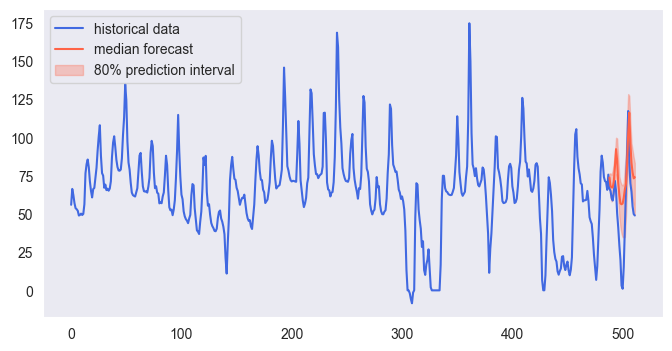

In [27]:
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df[target_column])[-512:] # Limit Context to last 512 Samples to better visualize it at end
forecast = pipeline.predict(context[:-prediction_length], prediction_length)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(context)-prediction_length, len(context))
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(context.numpy(), color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

# Further Work Ideas (Rather Advanced - Some HPC and LLM Experience Required)
## Finetuning
- Instead of forcasting unseen data train it on the series it shall forecast (was shown to lead to large improvements)
## New Tokenizers (Very Slow)
- Be as Creative as you want (More Tokens, Less Tokens, More Diverse Tokens, Complex Tokens, Longer Tokens, just different Tokens)
- (Note: Will require Pretraining Chronos might end up to be very slow --> Use extra small chronos during dev and plan in multiple weeks for training a single larger versions)
## Different Architecture (Very Slow)
- T5 the underlying Architecture Chronos uses is rather suboptimal (There are many much better models out there)
- You can replace the architecture --> Will require Week long Pretraining
## Use Chronos to Encode TS (Might be Very Interesting)
- LLMs can be used to encode Text or in our case TS into Vectors (such called embeddings) that can be used to represent the input, continue the sequence, or solve a bunch of other tasks
- Idea: one could extract the encoding (in theory without lengthy retraining) and use it as input to another model 
- One can be very Creative there most Neural Networks can work with Vectors (even AutoGluon-TimeSeries (AG-TS) with its Static features, and AutoGluon Tabular might be able to work with such embeddings) 
  - Idea1: Embeddings could help AG-TS to compare Time Series much better, Generalize better between them, and hence make better use of (much) more training data
  - Idea2: AG-Tabular is the core of AG and is much higher evolved already than AG-TS but it can't work with TS Data - However with embedded TS it's a different Story
  - Idea3: Basically any NN can work with Vectors so there should be no limit to your imagination